In [23]:
using QuantumOptics
using Statistics
using PyPlot
using Random
using JLD2
using CollectiveSpins

In [24]:
function avgSz(rho)
    Sz = [CollectiveSpins.mpc.sz(ρ) for ρ in rho]
    meanSz = [mean(subarray) for subarray in Sz]
    return meanSz
end

function prepare_theta_state(N_ES)
    return shuffle(vcat(zeros(Int, N_ES), ones(Int, N-N_ES)))*pi
end

function calcEvolutionMPC(λ, d_xy, d_z, Tstep, Tend, N_ES)
    a,b,c = [d_xy,d_xy,d_z]/λ
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)

    # Prepare the initial state: Half excited state
    phi_vec = zeros(N)
    theta_vec = prepare_theta_state(N_ES)
    Ψ0 = CollectiveSpins.mpc.blochstate(phi_vec, theta_vec)
    T = [0:Tstep:Tend;]
    tout, ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)
    meanSz = avgSz(ρt)
    return meanSz, tout, ρt
end

function calcSE_ind(Tstep, Tend, N)
    a,b,c = [1.,1.,1.] # SE -> indep of dimensions of the lattice
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)
    
    Ψ0 = CollectiveSpins.independent.blochstate(0., 0., N)
    T = [0:Tstep:Tend;]
    tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0, dt=Tstep)
    Sz = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
    meanSz_ind = [mean(subarray) for subarray in Sz]
    return meanSz_ind
end

""" Renormalize list of spins for independent case. Maps <σz> to go from [-1, 1] to [-1, 2N_ES/N - 1] """
function renorm_spin(list_spins, N_ES, N)
    return ((list_spins.+1) .* N_ES/N) .- 1
end

renorm_spin

In [25]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3] #5x5x3=75 sites takes about 6 seconds to calculate on my laptop (first time is slower ofcourse)
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.
λ = 1299

Tstep = 1e-3
Tend = 1;

### Computations

In [26]:
# Prepare matrix for all N_ES
MeanSz_array = zeros(N, Int.(Tend/Tstep) + 1)

for N_ES in 1:1:N
    println(string(N_ES)*"/"*string(N))
    MeanSz_array[N_ES, :] = calcEvolutionMPC(λ, d_xy, d_z, Tstep, Tend, N_ES)[1]
end

1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75
75/75


In [27]:
# Computation for independent spins
MeanSz_array_ind = zeros(N, Int.(Tend/Tstep) + 1)

for N_ES in 1:1:N
    MeanSz_array_ind[N_ES, :] = renorm_spin(calcSE_ind(Tstep, Tend, N), N_ES, N)
end

### Saving/loading data

In [28]:
# Save data
save_object("Vary_nbr_ES.jld2", MeanSz_array);

In [29]:
# Load data
MeanSz_array = load_object("Vary_nbr_ES.jld2");

### Plots decay

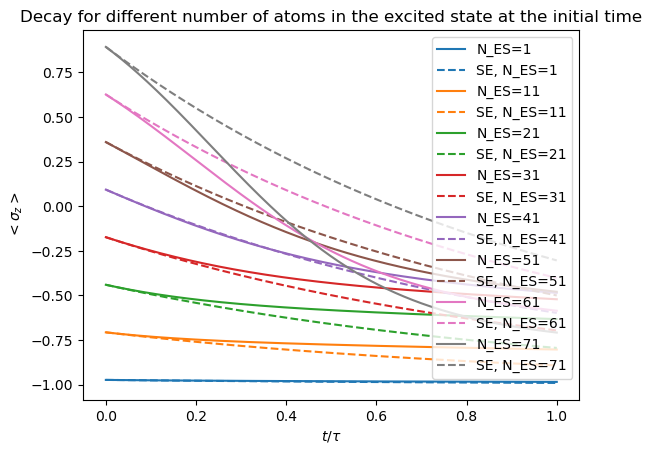

In [30]:
close("all")
figure()

# Plot of the decay from the excited states
for N_ES in 1:10:N
    plt = plot([0:Tstep:Tend;], MeanSz_array[N_ES, :], label="N_ES="*string(N_ES))
    plot([0:Tstep:Tend;], MeanSz_array_ind[N_ES, :], label="SE, N_ES="*string(N_ES), linestyle="--", color=plt[1].get_color())
end

title("Decay for different number of atoms in the excited state at the initial time")
xlabel(L"t/\tau")
ylabel(L"<\sigma_z>")
legend()
pygui(false); gcf()
#pygui(true), show()

# Light Emission

### Computations

In [31]:
# Compute Decay arrays
Decay_array = zeros(size(MeanSz_array)[1], size(MeanSz_array)[2]-1)
Decay_array_ind = zeros(size(MeanSz_array)[1], size(MeanSz_array)[2]-1)

for i in 1:size(Decay_array)[1]
    Decay_array[i, :] = -diff(MeanSz_array[i, :])/Tstep
    Decay_array_ind[i, :] = -diff(MeanSz_array_ind[i, :])/Tstep
end

### Plots

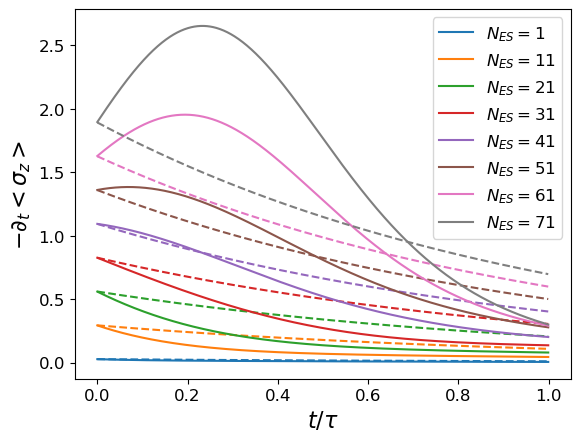

In [42]:
close("all")
figure()

PyPlot.rc("font", size = 12)

for i in 1:10:size(Decay_array)[1]
    plt = plot([0:Tstep:Tend-Tstep;], Decay_array[i, :], label=L"N_{ES}="*string(i))
    plot([0:Tstep:Tend-Tstep;], Decay_array_ind[i, :], linestyle="--", color=plt[1].get_color()) #, label=L"N_{ES, SE}="*string(i)
end

#title("Decay rate for different number of atoms in the excited state at the initial time")
xlabel(L"t/\tau", fontsize=16)
ylabel(L"-\partial_t{<σ_z>}", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Vary_NES_Decay_rate.pdf", bbox_inches="tight")

pygui(false); gcf()